In [1]:
!pip3 install pyspark wordcloud matplotlib numpy

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-10_2.12:3.1.1,org.apache.spark:spark-sql-kafka-0-10_2.12:3.1.1 pyspark-shell'

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
import pyspark

from IPython.display import display, clear_output
import time
from wordcloud import WordCloud, STOPWORDS

from time import sleep
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [4]:
spark = SparkSession \
        .builder \
        .master("spark://192.168.56.110:7077") \
        .config("spark.sql.streaming.schemaInference", True) \
        .appName("Spark + Kafka Total Wordcount") \
        .getOrCreate()

# Enable Arrow-based columnar data transfers
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", True)

# To always shoe the results of Dataframes and improve the formatting output
spark.conf.set("spark.sql.repl.eagerVal.enabled", True)

raw_df = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "192.168.56.110:9092") \
    .option("subscribe", "twitter-data") \
    .option("startingOffsets", "earliest") \
    .option("includeHeaders", "true") \
    .load()

raw_df.printSchema()

transformed_df = raw_df.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)", "timestamp")\
    .withColumn("timestamp", col("timestamp").cast(TimestampType())) \
    .select('timestamp', explode(split(col("value")," ")).alias("word"))

transformed_df.printSchema()

word_count = transformed_df
print(word_count)

:: loading settings :: url = jar:file:/usr/local/spark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/denni/.ivy2/cache
The jars for the packages stored in: /home/denni/.ivy2/jars
org.apache.spark#spark-streaming-kafka-0-10_2.12 added as a dependency
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-25bc64fa-2ee1-4a12-97b1-7951a35d9312;1.0
	confs: [default]
	found org.apache.spark#spark-streaming-kafka-0-10_2.12;3.1.1 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.1.1 in central
	found org.apache.kafka#kafka-clients;2.6.0 in central
	found com.github.luben#zstd-jni;1.4.8-1 in central
	found org.lz4#lz4-java;1.7.1 in central
	found org.xerial.snappy#snappy-java;1.1.8.2 in central
	found org.slf4j#slf4j-api;1.7.30 in central
	found org.spark-project.spark#unused;1.0.0 in central
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.1.1 in central
	found org.apache.commons#commons-pool2;2.6.2 in central
:: resolution report :: resolve 799ms :: artifacts

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)
 |-- headers: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- key: string (nullable = true)
 |    |    |-- value: binary (nullable = true)

root
 |-- timestamp: timestamp (nullable = true)
 |-- word: string (nullable = true)

DataFrame[timestamp: timestamp, word: string]


In [5]:
def generateWordCloud(df, df_id):
    clear_output(wait=True)
    timestamp_df = df.select('word', hour(col("timestamp")).alias("hour"))
    
    df = timestamp_df.groupBy("hour").count()
    pandas_df = df.toPandas()
    
    pandas_df.to_csv('./csv/total_word_counts.csv', mode='a')
    
    pandas_df.plot.bar(x="hour", y="count", rot=0)
    plt.show()

    df.write.format("console").save()

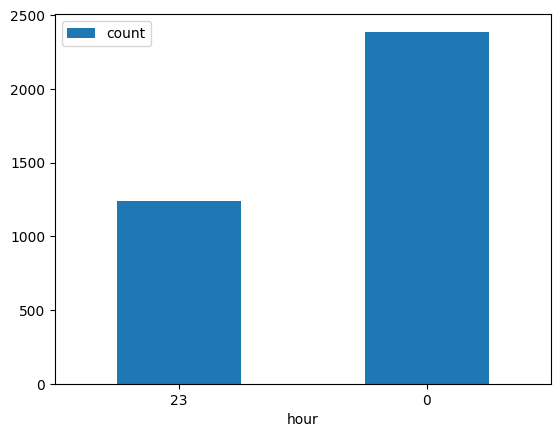

+----+-----+
|hour|count|
+----+-----+
|  23| 1237|
|   0| 2388|
+----+-----+



22/09/19 03:39:14 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 10000 milliseconds, but spent 17926 milliseconds


Finalizando streaming...


In [6]:
# Read the data stream. 
try:
    query_stream_memory = transformed_df \
        .writeStream \
        .foreachBatch(generateWordCloud) \
        .option("checkpointLocation", "/tmp/spark/total_wordcount") \
        .trigger(processingTime="10 seconds") \
        .outputMode("update") \
        .start() \
        .awaitTermination()
except KeyboardInterrupt:
    print("Finalizando streaming...")